# Import packages

In [1]:
from array import array
import itertools
import time

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from matplotlib.ticker import NullFormatter


Welcome to JupyROOT 6.09/01


# Defines how to get dataframe from ROOT TTree

In [18]:
def getData(inputFiles):
    
    cols = []
    cols.append('pt')
    cols.append('NN1')
    cols.append('l02')
    cols.append('b5x5_lin_flat')
    cols.append('b5x5_lin_relative')
    cols.append('b5x5_log_flat')
    cols.append('b5x5_log_relative')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=cols)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])

# Gets dataframes from dataset(s)

In [49]:
# NTuples found in /project/projectdirs/alice/NTuples
mcFiles = ["fout_b5x5.root"]#["16c3b_small.root"]
dataFiles = ["fout_b5x5.root"]#,"13e_small.root",'13e_small.root']
mcHists = getData(mcFiles)
dataHists = getData(dataFiles)

Processed fout_b5x5.root in 0.0278270244598 seconds
Processed fout_b5x5.root in 0.0431618690491 seconds


In [35]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*cutDataframe.shape[0]/float(nbeforecut))
    return cutDataframe

In [54]:
def applyCuts(fullDataframe):  
    
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'l02<1.0', 'lambdacut')
    dataframe = applyCut(dataframe, 'b5x5_lin_flat<1.0', 'b5x5_lin_flat<2.0')
    dataframe = applyCut(dataframe, 'b5x5_log_flat<1.0', 'b5x5_log_flat<2.0')
    dataframe = applyCut(dataframe, 'b5x5_lin_relative<1.0', 'b5x5_lin_relative<2.0')
    dataframe = applyCut(dataframe, 'b5x5_log_relative<1.0', 'b5x5_log_relative<2.0')
    return dataframe

# Define plotting 

In [55]:
dataHists = applyCuts(dataHists)
mcHists = applyCuts(mcHists)

lambdacut 23313  fraction kept: 95.8
b5x5_lin_flat<2.0 22547  fraction kept: 96.7
b5x5_log_flat<2.0 21528  fraction kept: 95.5
b5x5_lin_relative<2.0 21391  fraction kept: 99.4
b5x5_log_relative<2.0 21096  fraction kept: 98.6
lambdacut 23313  fraction kept: 95.8
b5x5_lin_flat<2.0 22547  fraction kept: 96.7
b5x5_log_flat<2.0 21528  fraction kept: 95.5
b5x5_lin_relative<2.0 21391  fraction kept: 99.4
b5x5_log_relative<2.0 21096  fraction kept: 98.6


In [38]:
def plotcorr(histo,label,figname,xvar,yvar,nbins=100):
    y = histo[yvar]
    x = histo[xvar]
    nullfmt = NullFormatter()         # no labels
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.04
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    fig = plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(nullfmt) #no labels
    axHisty.yaxis.set_major_formatter(nullfmt)
    hb = axScatter.hexbin(x, y, cmap='viridis')#, gridsize=100)#, gridsize=500) #gridsize=60
    #axScatter.plot((0, 1), (0.27, 0.27), 'r-',linestyle=':')
    
    #axScatter.plot((0.245, 0.245), (0, 1.0), 'r-',linestyle=':')
    #axScatter.plot((0.255, 0.255), (0, 1.0), 'r-',linestyle=':')
    plt.text(0.22, 0.90,label, horizontalalignment='center',  verticalalignment='center', transform=axScatter.transAxes, bbox=dict(facecolor='white', alpha=0.75))
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    #axScatter.set_xlim((0.0, 1.0))
    #axScatter.set_ylim((0.0, 1.0))
    axScatter.set_ylabel(yvar)
    axScatter.set_xlabel(xvar)
    yhist, xhist, patches = axHistx.hist(x,nbins)#, range=(0, 1.0)) #here it gets the NN histogram
    xhist= np.delete(xhist,-1)
    xhist = np.add( xhist, (xhist[1]-xhist[0])/2.0 )
    yerrhist = np.sqrt(yhist)
    xerrhist = np.full(len(yerrhist), (xhist[1]-xhist[0])/2.0)
    axHisty.hist(y,nbins, orientation='horizontal') #range=(0.0,1.0)
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    plt.show()
    #plt.clf()
    #plt.close()
    #plt.hist(y,nbins, range=(0.0,1.0))
    fig.savefig('../JupyterPNGOutput/'+figname+xvar+yvar+'.png', dpi=fig.dpi)
    return yhist, xhist, yerrhist, xerrhist
    

# Function to cut pt ranges

In [39]:
def cutptrange(data, ptmin, ptmax):
    datacut = data.query('pt>%f and pt<%f' %(ptmin,ptmax))
    print 'number of clusters after cut', datacut.shape[0]
    return datacut

# Define pt bins and plot

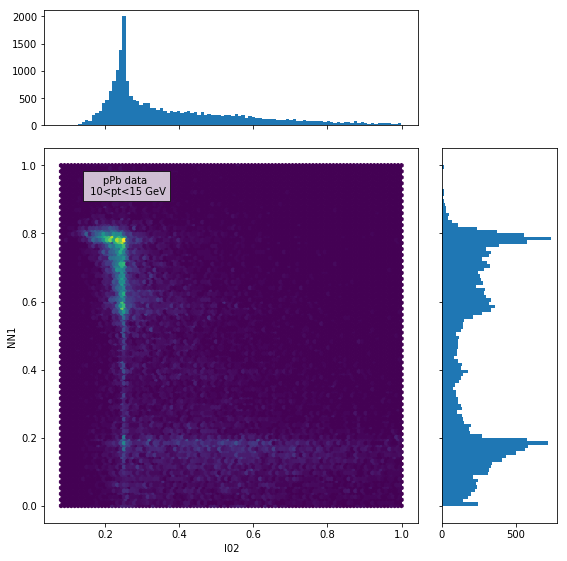

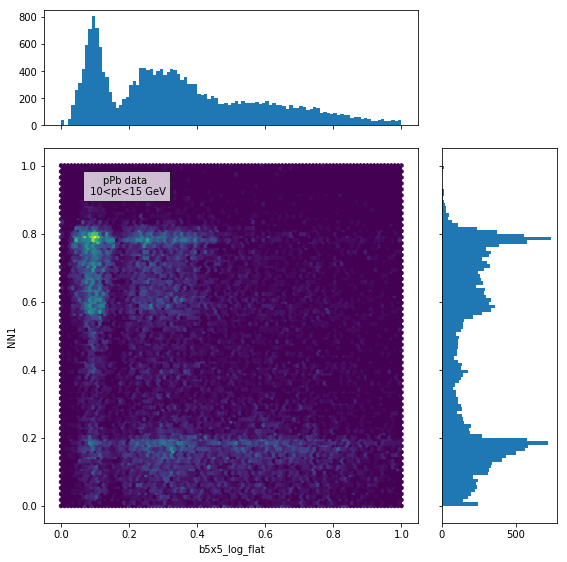

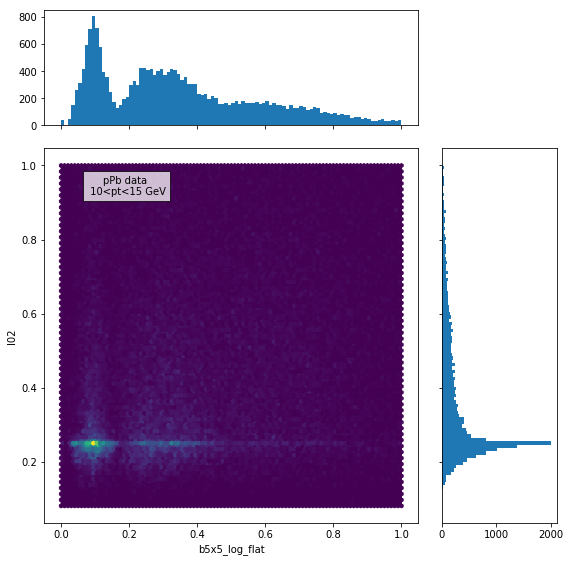

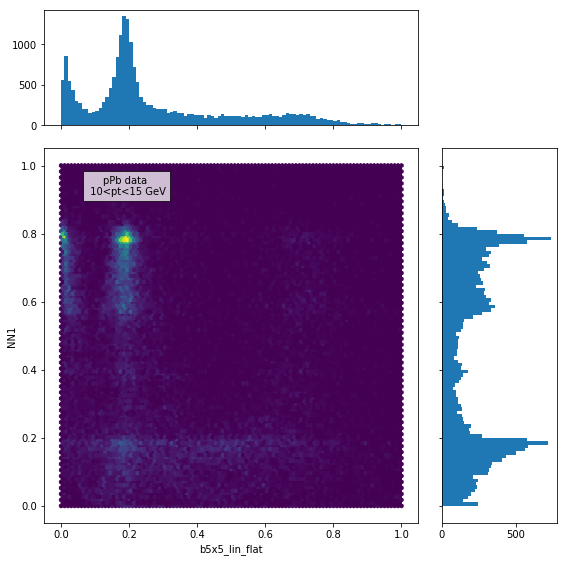

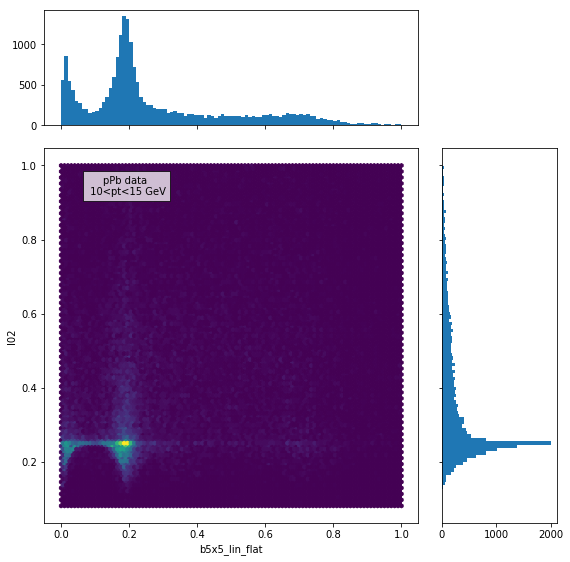

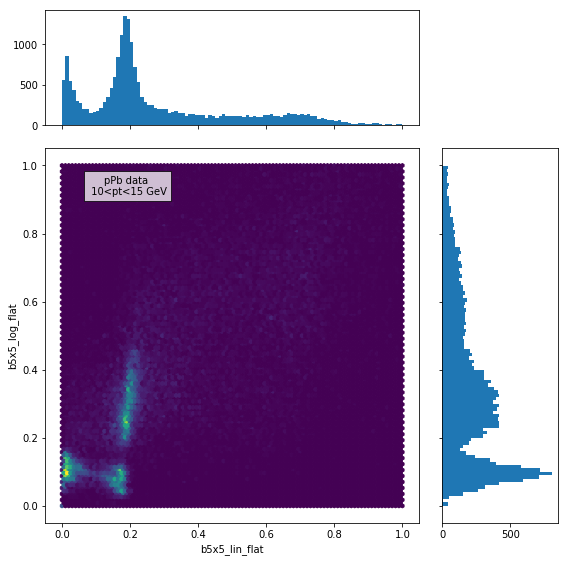

number of clusters after cut 21096


In [57]:
binedges = [10.0, 15.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    datacut= cutptrange(dataHists, ptmin, ptmax)
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax),'l02','NN1')
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax),'b5x5_log_flat','NN1')
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax),'b5x5_log_flat','l02')
    
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax),'b5x5_lin_flat','NN1')
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax),'b5x5_lin_flat','l02')
    plotcorr(datacut,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax),'b5x5_lin_flat','b5x5_log_flat')



    
    ##dealing with MC
    #mcdatacut = cutptrange(mcHists, ptmin, ptmax)
    #plotcorr(mcdatacut,'Dijet MC \n %2.0f<pT<%2.0f GeV' %(ptmin,ptmax),'all_MC_%2.0f_%2.0f' %(ptmin,ptmax))
    
    
    

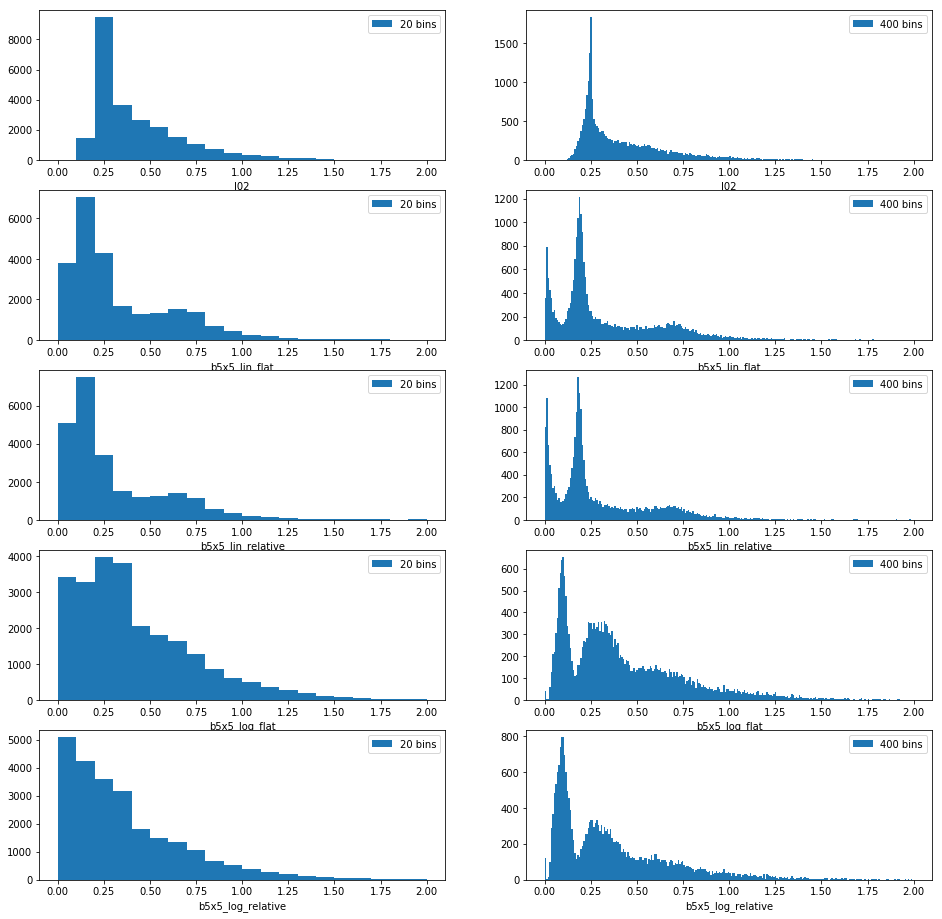

number of clusters after cut 24338


In [53]:
binedges = [10.0, 15.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    datacut= cutptrange(dataHists, ptmin, ptmax)
    
    
    fig = plt.figure(figsize=(16,16))
    names = ['l02','b5x5_lin_flat','b5x5_lin_relative', 'b5x5_log_flat', 'b5x5_log_relative']
    for i, name in enumerate(names):
        plt.subplot(5,2,2*i+1)
        plt.hist(datacut[name], bins=20, range=(0.0,2.0),label='20 bins')
        plt.xlabel(name)
        plt.legend()
        plt.subplot(5,2,2*i+2)
        plt.hist(datacut[name], bins=250, range=(0.0,2.0),label='400 bins')
        plt.xlabel(name)
        plt.legend()
    
    plt.show()
    
    fig.savefig('../JupyterPNGOutput/LambdaAndB5x5.png', dpi=fig.dpi)
 
     
    

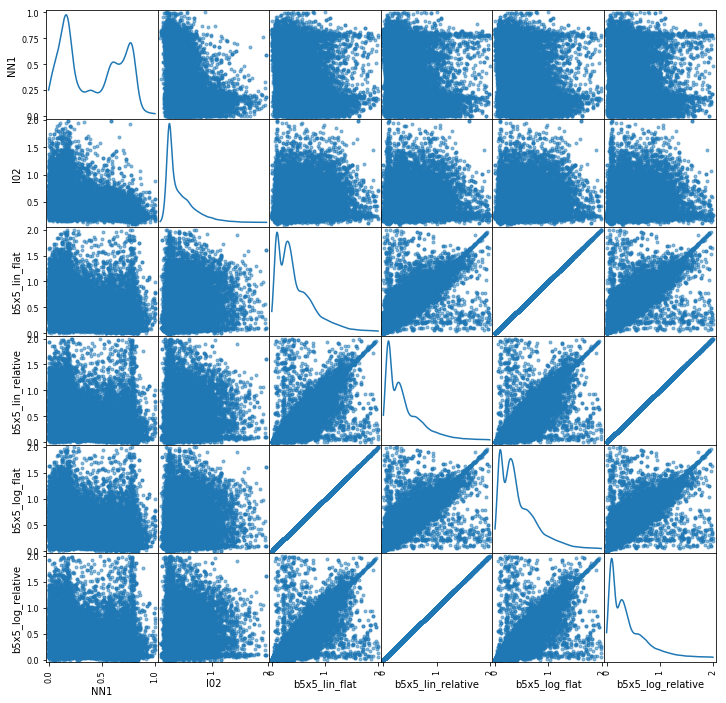

number of clusters after cut 25257


In [44]:
binedges = [10.0, 15.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    datacut= cutptrange(dataHists, ptmin, ptmax)
    datacut = datacut.drop(['pt'], axis=1)
        
    fig = plt.figure(figsize=(12,12))
    pd.scatter_matrix(datacut, diagonal='kde',figsize=(12,12))
    plt.show()
